## MUSCO


Cette maladie est causée par la modification d’un gène responsable de la fabrication de la
protéine dystrophine, laquelle contribue à la force et la santé des muscles. Cette modification
est ce qu’on appelle une mutation. Lorsque ce gène subit une mutation, la protéine
dystrophine ne s’acquitte plus de sa fonction. Les cellules musculaires s’affaiblissent et se
détruisent peu à peu. Rarissime chez les filles, cette maladie affecte surtout les garçons. Nous
disposons de quatre variables pouvant être utilisés comme prédicteurs de cette maladie : la
créatine kinase, l’hemopexine, la lactate dehydrogénase et la pyruvate kinase (enzymes).

In [26]:
import pandas as pd
from sklearn import datasets
from sklearn.metrics import confusion_matrix

In [27]:
musco = pd.read_csv('musco.txt', delimiter='\t')
print(musco)

    AGE  CREATKIN  HEMOPEX  LACTDEHY  PYRUKIN  CARRIER
0    22       5.2      8.4       1.1     17.6        1
1    32       2.0      7.7       1.1     20.0        1
2    36       2.8      8.7       1.3     17.1        1
3    22       3.0     10.4       2.3     23.0        1
4    23       4.0      8.3       1.5     20.5        1
..  ...       ...      ...       ...      ...      ...
68   38      11.3      9.7       1.9     21.6        2
69   30       5.7     10.5       1.3     15.5        2
70   42       7.8     11.8       1.6     21.2        2
71   43       7.3     10.4       2.1     20.1        2
72   29       6.9     11.1       1.6     17.5        2

[73 rows x 6 columns]


In [28]:
musco = musco.to_numpy()
X = musco[:,0:5] #variables descriptives
y = musco[:,-1] #variable binaire à expliquer

Nous sommes ici en présence d'un jeu de données à 5 variebles quantitatives et une variable qualitative (CARRIER) qui est la variable qui nous intéresse ) expliquer (elle représente si les individus sont atteints ou pas par la maladie). Cette variable est binaire et il est donc raisonnable de choisir un modèle de régression logistique adapté à expliquer une variable binaire par des variables quantitatives, et réaliser des prédictions sur des éventuelles valeurs futures. On réalise d'abord une régression logistique afin d'évaluer la pertinence et la significativité des variables quantitatives sur la variable CARRIER.

## I. Régression logistique 

In [29]:
import statsmodels.discrete.discrete_model as sm

y = y-1 #transformation en variable binaire qui prend 1 et 0 pour pouvoir passer par Logit
glm = sm.Logit(y,X)
result = glm.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.521193
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   73
Model:                          Logit   Df Residuals:                       68
Method:                           MLE   Df Model:                            4
Date:                Sat, 25 May 2024   Pseudo R-squ.:                  0.2455
Time:                        23:56:12   Log-Likelihood:                -38.047
converged:                       True   LL-Null:                       -50.428
Covariance Type:            nonrobust   LLR p-value:                 5.615e-05
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0187      0.036      0.514      0.608      -0.053       0.090
x2             0.1590      0.080      1.993      0.046       0.003       0.315
x3            -0.4924      0.176     -2.791      0.005      -0.838      -0.147
x4             0.4606      0.439      1.050      0.294      -0.399       1.321
x5             0.0953      0.061      1.566      0.117      -0.024       0.215
==============================================================================
"""

On remarque que les p-values associées à la significativité des coefficients associés aux variables 'CREATKIN' et 'LACTDEHY' sont inférieures à 0.05. Ces covariables semblent être les plus significatives dans ce modèle qui étudie l'influence de toutes les variables conjointement.

### Sélection des variables

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
Ir = LogisticRegression()
selecteur = RFE(estimator=Ir)
sol = selecteur.fit(X,y)

In [31]:
print(sol.n_features_)

2


On a donc deux variables pertinentes

In [32]:
print(sol.support_)

[False False  True  True False]


Les variables 'HEMOPEX' et 'LACTDEHY' sont donc les plus pertinentes d'après le selecteur.

In [33]:
print(sol.ranking_)

[4 2 1 1 3]


Classement de la pertinence des variables ('HEMOPEX' et 'LACTDEHY' en premiere ligne)

In [34]:
Xs = X[:,sol.support_]

Xs représente le modèle optimisé qui prend en compte les modalités les plus significatives selon RFE

### Entrainement du modèle / Evaluation de sa qualité

In [35]:
GLM= LogisticRegression(max_iter=200)
GLM.fit(Xs,y)
y_pred=GLM.predict(Xs)

MC = confusion_matrix(y_pred,y)
score = GLM.score(Xs,y)

print("Matrice de confusion:")
print(MC)

print("Score du modèle :", score)

Matrice de confusion:
[[33  7]
 [ 6 27]]
Score du modèle : 0.821917808219178


### Courbe de ROC

In [37]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

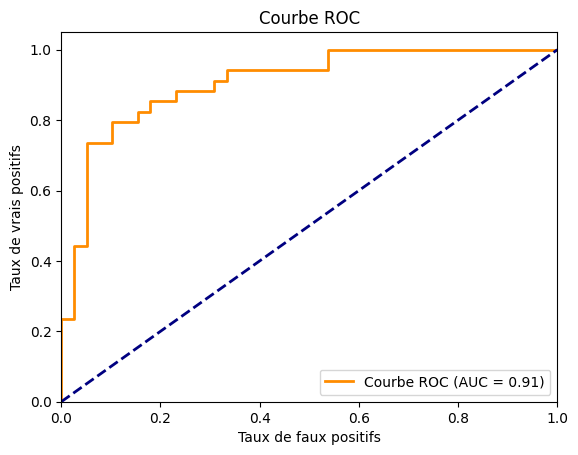

In [38]:
y_probs = GLM.predict_proba(Xs)

fpr, tpr, thresholds = roc_curve(y, y_probs[:,1])

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Courbe ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

L'AUC est proche de 1 donc notre modèle est globalement bon. Les prédictions restent néanmoins critiquables. On essaye de procéder par analyse discriminante.

## II. Analyse discriminante

Comme vu précedemment dans l'étude, les variables 'HEMOPEX' et 'LACTDEHY' expliquent la variable réponse 'CARRIER' de la manière la plus significative. On se propose donc de représenter un nuage de points en fonction des valeurs en ces deux variables explicatives, en les étiquétant selon leur variables 'CARRIER'.

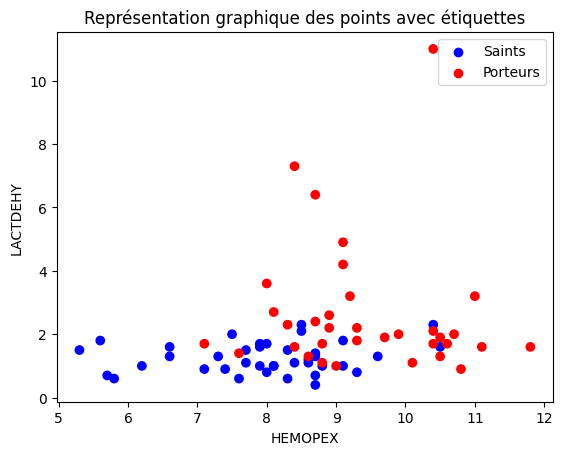

In [39]:
import matplotlib.pyplot as plt

x1 = Xs[:, 0]  # HEMOPEX
x2 = Xs[:, 1]  # LACTDEHY
y = musco[:, -1]  # CARRIER

colors = ['blue' if label ==  1 else 'red' for label in y]

# Représentation du nuage de points avec étiquettes
plt.scatter(x1, x2, c=colors)

plt.scatter([], [], color='blue', label='Saints')
plt.scatter([], [], color='red', label='Porteurs')

plt.xlabel('HEMOPEX')
plt.ylabel('LACTDEHY')
plt.legend()


plt.title('Représentation graphique des points avec étiquettes')
plt.show()

Le graphique confirme la possibilité de séparer géométriquement les points en deux groupes, d'où le recours à l'analyse discriminante

## Entrainement du modèle / Evaluation de sa qualité

### 1. Analyse Discriminante Linéaire

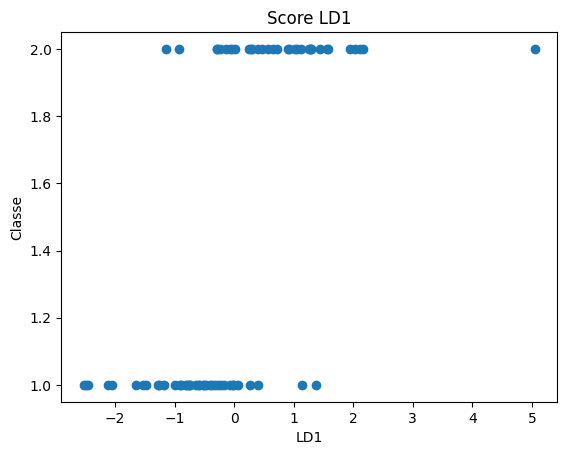

In [40]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

lda = LinearDiscriminantAnalysis()
lda.fit(Xs, y)
LD1 = lda.transform(Xs)

plt.scatter(LD1, y)
plt.title('Score LD1')
plt.xlabel('LD1')
plt.ylabel('Classe') 
plt.show()

On voit donc une discrimination possible entre les deux classes

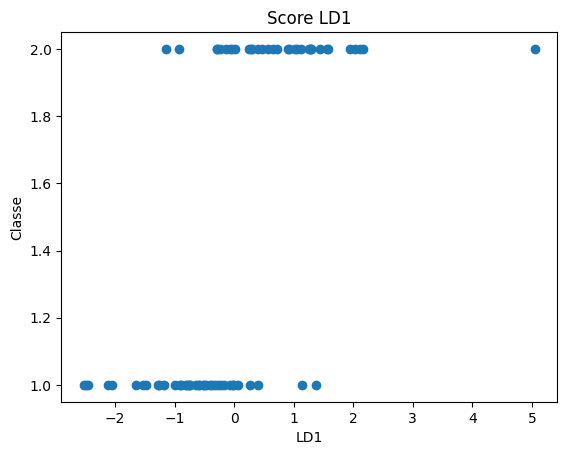

In [41]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

lda = LinearDiscriminantAnalysis()
lda.fit(Xs, y)
LD1 = lda.transform(Xs)

plt.scatter(LD1, y)
plt.title('Score LD1')
plt.xlabel('LD1')
plt.ylabel('Classe') 
plt.show()

On remarque que le score de ce modèle est équivalent au modèle de régression logistique

Comme les groupes ne semblent pas être de variance égale, on tente de faire une analyse discrimante quadratique plutôt que linéaire

### 2. Analyse Discriminante Quadratique

In [42]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

qda = QuadraticDiscriminantAnalysis()

qda.fit(Xs, y)

y_pred = qda.predict(Xs)


score = qda.score(Xs, y)
print("Score du modèle QDA :", score)

conf_matrix = confusion_matrix(y, y_pred)
print("Matrice de confusion :\n", conf_matrix)

Score du modèle QDA : 0.8356164383561644
Matrice de confusion :
 [[36  3]
 [ 9 25]]


Le score global est légèrement plus élevé qu'en LDA. Cependant, le modèle LDA a une meilleure capacité à prédire les individus atteints. En effet le modèle QDA possède un faible taux de faux positifs et un taux élevé de faux négatifs, tandis que le modèle LDA possède un faible taux de faux négatifs et un taux élevé de faux positifs. Vu le contexte médical des données, on préférera le modèle LDA au modèle QDA, puisqu'on préfère se tromper sur les individus saints plutôt que sur les individus atteints.